# generate 5 days data

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import datetime

In [ ]:
df = pd.DataFrame()
chunksize = 10 ** 6

for i in glob.glob("pubg stats dataset/aggregate/agg_match_stats*"):
    with pd.read_csv(i, chunksize=chunksize) as reader:
        for chunk in reader:
            chunk['dt'] = pd.to_datetime(chunk['date']).dt.normalize()
            df = pd.concat([df,chunk[chunk['dt']>=tmp]],ignore_index=True)
    print(df.shape)
    
df.to_csv("pubg stats dataset/agg_5_days.csv",index=False)

df1 = pd.read_csv("pubg stats dataset/agg_5_days.csv")

lst = df1.match_id.unique()
df = pd.DataFrame()
chunksize = 10 ** 6

for i in glob.glob("pubg stats dataset/deaths/kill_match_stats_final*"):
    with pd.read_csv(i, chunksize=chunksize) as reader:
        for chunk in reader:
            df = pd.concat([df,chunk[chunk['match_id'].isin(lst)].copy()],ignore_index=True)
    print(df.shape)
    
df.to_csv("pubg stats dataset/deaths_5_days.csv",index=False)

# merging data and creating final dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn import metrics
import pandas as pd
import time
import math
# %matplotlib inline
# sns.set_context('poster')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [ ]:
df = pd.read_csv("pubg stats dataset/agg_5_days.csv")
df1 = pd.read_csv("pubg stats dataset/deaths_5_days.csv")

df = df.dropna().reset_index(drop=True)
df1 = df1.dropna().reset_index(drop=True)
df1 = df1[(df1.killer_name!='#unknown') & (df1.victim_name!='#unknown') & (df1.victim_name!=df1.killer_name)].reset_index(drop=True)

In [ ]:
df2 = df1.groupby(['match_id','killer_name','map']).agg({"killed_by":lambda x: list(x),"killer_position_x":lambda x: list(x),"killer_position_y":lambda x: list(x),
                                                        "time":lambda x: list(x),"victim_position_x":lambda x: list(x),"victim_position_y":lambda x: list(x)}).reset_index()

def avg_distance_between_kill(x):
    lis = list(zip(x['time'],x['killed_by'],x['killer_position_x'],x['killer_position_y'],x['victim_position_x'],x['victim_position_y']))
    kill_distance = []
    for i in lis:
        kill_distance.append(math.sqrt(math.pow(i[5]-i[3],2)+math.pow(i[4]-i[2],2)))
    lis = sorted(lis, key=lambda x: x[0])
    lis = list(zip(lis,lis[1:]))
    avg_dis = []
    for i in lis:
        avg_dis.append(math.sqrt(math.pow(i[1][3]-i[0][3],2)+math.pow(i[1][2]-i[0][2],2)))
    return kill_distance,avg_dis,np.mean(avg_dis),min(avg_dis+[0]),max(avg_dis+[0])

df2[['kill_distance','distance_between_kill','avg_distance_between_kill','min_distance_between_kill','max_distance_between_kill']] = df2.apply(lambda x: avg_distance_between_kill(x),axis=1,result_type='expand')
df2['min_distance_between_kill'] = df2['distance_between_kill'].apply(lambda x: 0.0 if len(x)==0 else min(x))

tmp_df = pd.merge(df,df2,how='left',left_on=['match_id','player_name'],right_on=['match_id','killer_name'])
tmp_df.to_csv('merged_data.csv',index=False)

# feature selection & clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn import metrics
# from jqmcvi import base
# from fsfc.generic import NormalizedCut
# from sklearn.pipeline import Pipeline
import pandas as pd
import time
import math
# %matplotlib inline
# sns.set_context('poster')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/merged_data.csv')

In [4]:
tmp = df['player_name'].unique()
dic_name = dict(zip(range(len(tmp)),tmp))
dic1_name = dict(zip(tmp,range(len(tmp))))
df['player_name']=df['player_name'].apply(lambda x: dic1_name[x])
tmp = df['map'].unique()
dic_map = dict(zip(range(len(tmp)),tmp))
dic1_map = dict(zip(tmp,range(len(tmp))))
df['map']=df['map'].apply(lambda x: dic1_map[x])


In [5]:
df_sqad = df[df.party_size==4]

df_sqad = df_sqad[df_sqad.killer_name.notna()]
df_sqad = df_sqad[df_sqad.avg_distance_between_kill.notna()]
cols = ['player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk',
        'player_dmg', 'player_kills', 'player_survive_time',
        'team_placement', 'avg_distance_between_kill', 'min_distance_between_kill',
        'max_distance_between_kill']

df_sqad1 = df_sqad[cols]

In [10]:
df.describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_name,player_survive_time,team_id,team_placement,map,avg_distance_between_kill,min_distance_between_kill,max_distance_between_kill
count,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,5.184357e+06,1.029174e+06,2.081147e+06,2.081147e+06
mean,4.443145e+01,2.849384e+00,2.288293e-01,6.168707e-01,1.031544e+03,1.269111e+03,1.240666e+02,8.836565e-01,6.321659e+05,7.540018e+02,1.766534e+04,2.308671e+01,6.132724e-01,4.249089e+04,1.186593e+04,3.631196e+04
std,2.344700e+01,1.227419e+00,5.676266e-01,1.171519e+00,1.796799e+03,1.298743e+03,1.717699e+02,1.565410e+00,4.711547e+05,5.701716e+02,3.812897e+04,1.914297e+01,8.129317e-01,7.743354e+04,5.188915e+04,8.808557e+04
min,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.700000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.969236e+02,0.000000e+00,0.000000e+00,2.285880e+05,2.306930e+02,1.100000e+01,9.000000e+00,0.000000e+00,2.123790e+03,0.000000e+00,0.000000e+00
50%,3.000000e+01,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.928246e+02,7.800000e+01,0.000000e+00,5.337500e+05,5.892140e+02,2.100000e+01,1.900000e+01,0.000000e+00,1.078368e+04,0.000000e+00,0.000000e+00
75%,4.900000e+01,4.000000e+00,0.000000e+00,1.000000e+00,1.574305e+03,2.097889e+03,1.740000e+02,1.000000e+00,9.698530e+05,1.248536e+03,3.800000e+01,2.900000e+01,1.000000e+00,5.002916e+04,1.742834e+03,1.500081e+04
max,1.000000e+02,4.000000e+00,1.300000e+01,4.700000e+01,1.281865e+05,1.401782e+05,5.618000e+03,5.400000e+01,1.761326e+06,2.303992e+03,1.001210e+05,1.000000e+02,2.000000e+00,9.184453e+05,9.184453e+05,9.184453e+05


In [11]:
from scipy.stats import zscore
df_sqad1.sample(10000).apply(zscore).describe()

,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_placement,avg_distance_between_kill,min_distance_between_kill,max_distance_between_kill
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-3.836931e-17,3.552714e-19,1.090683e-16,7.105427e-18,1.048051e-16,-3.126388e-17,-1.776357e-16,-9.094947e-17,-1.115552e-16,2.877698e-17,1.335820e-16
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-6.683917e-01,-1.337449e+00,-8.041138e-01,-1.519009e+00,-1.394140e+00,-1.491658e+00,-1.937824e+00,-1.228022e+00,-5.029107e-01,-3.065665e-01,-6.066042e-01
25%,-6.683917e-01,-3.224999e-01,-8.041138e-01,-9.165337e-01,-6.064253e-01,-5.656226e-01,-9.450339e-01,-9.534439e-01,-4.803696e-01,-3.026851e-01,-5.872054e-01
50%,-6.683917e-01,-3.224999e-01,-4.242824e-01,-3.316641e-02,-2.302032e-01,-1.026048e-01,2.115247e-01,-2.669994e-01,-3.977511e-01,-2.869179e-01,-5.014361e-01
75%,4.225038e-01,1.849744e-01,5.916224e-01,7.307675e-01,2.753452e-01,3.604131e-01,8.951873e-01,8.313117e-01,2.896178e-02,-2.160498e-01,2.314665e-01
max,1.242235e+01,1.693163e+01,5.776638e+00,5.399407e+00,1.398786e+01,1.795509e+01,1.833497e+00,2.753356e+00,9.804030e+00,1.075738e+01,6.539735e+00


In [ ]:
y = df_sqad['team_placement'].values
for i in df_sqad1.columns:
    print(i)
    x=df_sqad1[i].values
#     q25, q75 = np.percentile(x, [25, 75])
#     bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
#     if bin_width==0.0:
#         bin_width=1
#     bins = round((x.max() - x.min()) / bin_width)
#     print(bins)
#     plt.hist(x, density=True, bins=150)
    plt.scatter(x,y)
    plt.show()

In [50]:
cols = []
sc1 = []
for _ in range(8):
    sc = []
    for i in np.setdiff1d(df_sqad1.columns, cols):
        for k in range(2,11):
            tmp = df_sqad1[cols+[i]].values
            km = cluster.KMeans(n_clusters=k,n_init='auto')
            km = km.fit(tmp)
            t = km.labels_
            print(set(t),[(i,np.count_nonzero(t == i)) for i in set(t)])
            if len(set(t))==1:
                t=-1
            else:
                t = metrics.davies_bouldin_score(tmp, km.labels_) # silhouette_score
            print({"cols":cols+[i],"cluster_size":k,"error":t,"error1":km.inertia_})
            sc.append((cols+[i],k,t))
    sc = sorted(sc,key=lambda x: x[2])
    sc1.append(sc)
    cols.append(sc[0][0][-1])
    print(cols)

{0, 1} [(0, 480247), (1, 33854)]
{'cols': ['avg_distance_between_kill'], 'cluster_size': 2, 'error': 0.4965026663187866, 'error1': 1246220345433087.0}
{0, 1, 2} [(0, 437266), (1, 10533), (2, 66302)]
{'cols': ['avg_distance_between_kill'], 'cluster_size': 3, 'error': 0.49916487048932684, 'error1': 593007889157173.8}
{0, 1, 2, 3} [(0, 401319), (1, 23571), (2, 5317), (3, 83894)]
{'cols': ['avg_distance_between_kill'], 'cluster_size': 4, 'error': 0.48434052445812037, 'error1': 330255387000178.44}
{0, 1, 2, 3, 4} [(0, 35345), (1, 370337), (2, 4240), (3, 13269), (4, 90910)]
{'cols': ['avg_distance_between_kill'], 'cluster_size': 5, 'error': 0.4904799159409373, 'error1': 211341409845074.28}
{0, 1, 2, 3, 4, 5} [(0, 358404), (1, 39254), (2, 6660), (3, 90048), (4, 2891), (5, 16844)]
{'cols': ['avg_distance_between_kill'], 'cluster_size': 6, 'error': 0.49615868527330037, 'error1': 149012852721649.53}
{0, 1, 2, 3, 4, 5, 6} [(0, 43945), (1, 345419), (2, 3905), (3, 9895), (4, 88517), (5, 20756), (6,

5
1519269041524.6082
{0, 1} [(0, 176579), (1, 337522)]
879639681058.3721
{0, 1, 2} [(0, 175855), (1, 126664), (2, 211582)]
631774225724.9014
{0, 1, 2, 3} [(0, 204868), (1, 57449), (2, 121280), (3, 130504)]
540143822594.2814
{0, 1, 2, 3, 4} [(0, 118770), (1, 168370), (2, 83565), (3, 93289), (4, 50107)]
462884411313.82837
{0, 1, 2, 3, 4, 5} [(0, 70865), (1, 165561), (2, 80740), (3, 37652), (4, 89252), (5, 70031)]
387730818474.8544
{0, 1, 2, 3, 4, 5, 6} [(0, 64041), (1, 167856), (2, 23240), (3, 57995), (4, 61029), (5, 65298), (6, 74642)]
350440001165.5504
{0, 1, 2, 3, 4, 5, 6, 7} [(0, 71246), (1, 46840), (2, 163539), (3, 17037), (4, 52059), (5, 57450), (6, 59258), (7, 46672)]
317237349818.6483
{0, 1, 2, 3, 4, 5, 6, 7, 8} [(0, 47774), (1, 50961), (2, 162891), (3, 57851), (4, 39326), (5, 12673), (6, 35232), (7, 43919), (8, 63474)]
288974193397.4259
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} [(0, 55431), (1, 57400), (2, 35895), (3, 55496), (4, 45722), (5, 139557), (6, 46730), (7, 32857), (8, 33668), (9,

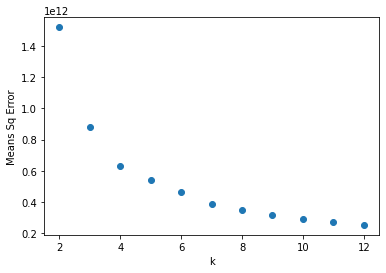

6
1519270160711.4004
{0, 1} [(0, 176552), (1, 337549)]
879646118440.2926
{0, 1, 2} [(0, 126459), (1, 176168), (2, 211474)]
631775330186.8479
{0, 1, 2, 3} [(0, 56202), (1, 122573), (2, 205087), (3, 130239)]
540133077328.3347
{0, 1, 2, 3, 4} [(0, 169531), (1, 49147), (2, 94055), (3, 118090), (4, 83278)]
454876385949.3401
{0, 1, 2, 3, 4, 5} [(0, 73144), (1, 72639), (2, 93430), (3, 27213), (4, 188757), (5, 58918)]
387722413383.0814
{0, 1, 2, 3, 4, 5, 6} [(0, 74967), (1, 61219), (2, 22547), (3, 167640), (4, 58731), (5, 64787), (6, 64210)]
356071967444.324
{0, 1, 2, 3, 4, 5, 6, 7} [(0, 63071), (1, 63459), (2, 37616), (3, 59738), (4, 22279), (5, 62006), (6, 141526), (7, 64406)]
320949899861.7686
{0, 1, 2, 3, 4, 5, 6, 7, 8} [(0, 141326), (1, 51189), (2, 61338), (3, 56686), (4, 54186), (5, 13762), (6, 41782), (7, 59159), (8, 34673)]
288974683390.3676
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} [(0, 57602), (1, 33395), (2, 139688), (3, 55530), (4, 55558), (5, 35624), (6, 45679), (7, 46968), (8, 32902), (9, 1

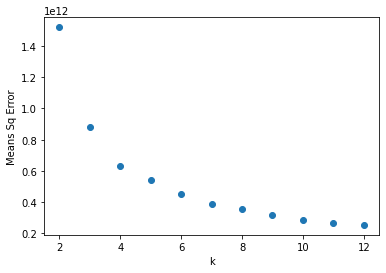

7
1639050921030.6575
{0, 1} [(0, 185182), (1, 328919)]
927184277954.27
{0, 1, 2} [(0, 126774), (1, 208988), (2, 178339)]
679960631519.1813
{0, 1, 2, 3} [(0, 56256), (1, 125059), (2, 202892), (3, 129894)]
580112208282.1841
{0, 1, 2, 3, 4} [(0, 92544), (1, 118111), (2, 166653), (3, 87269), (4, 49524)]
499196988530.4143
{0, 1, 2, 3, 4, 5} [(0, 163901), (1, 71519), (2, 78723), (3, 96979), (4, 77430), (5, 25549)]
424708210405.9181
{0, 1, 2, 3, 4, 5, 6} [(0, 73764), (1, 65044), (2, 57894), (3, 67582), (4, 163129), (5, 23245), (6, 63443)]
386065627479.3248
{0, 1, 2, 3, 4, 5, 6, 7} [(0, 56064), (1, 71144), (2, 45508), (3, 160334), (4, 55974), (5, 48686), (6, 15851), (7, 60540)]
353416538658.3092
{0, 1, 2, 3, 4, 5, 6, 7, 8} [(0, 16243), (1, 66060), (2, 34659), (3, 46327), (4, 52341), (5, 140702), (6, 52219), (7, 46324), (8, 59226)]
321057478762.69995
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} [(0, 43425), (1, 55015), (2, 134785), (3, 35301), (4, 44371), (5, 36278), (6, 36702), (7, 57349), (8, 11501), (9, 5

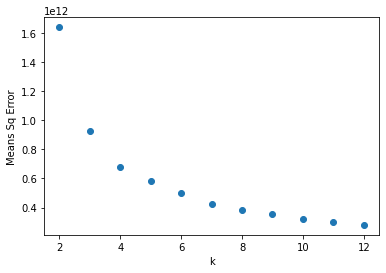

In [47]:
for j in range(5,8):
    print(j)
    arr = []
    for k in range(2,13):
        km = cluster.KMeans(n_clusters=k,n_init='auto')
        km = km.fit(df_sqad1[cols[:j]].values)
        print(km.inertia_)
        t = km.labels_
        print(set(t),[(i,np.count_nonzero(t == i)) for i in set(t)])
        arr.append(km.inertia_)
    plt.scatter(list(range(2,len(arr)+2)), arr)
    plt.xlabel('k')
    plt.ylabel('Means Sq Error')
    plt.show()

In [40]:
km = cluster.KMeans(n_clusters=6)
km = km.fit(df_sqad[cols[:6]].values)
print(km.inertia_)
t = km.labels_
print(set(t),[(i,np.count_nonzero(t == i)) for i in set(t)])
df_sqad['predict'] = km.labels_
df_sqad['tmp'] = df_sqad.apply(lambda x: x['team_placement']/x['game_size'],axis=1)
df_sqad.groupby('predict').agg({'tmp':np.mean})

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


454859722772.5791
{0, 1, 2, 3, 4, 5} [(0, 189156), (1, 71738), (2, 94556), (3, 59410), (4, 26032), (5, 73209)]


,tmp
predict,
0,0.631458
1,0.196221
2,0.198713
3,0.134673
4,0.164031
5,0.319440


In [43]:
cols[:7]

['player_assists',
 'player_dbno',
 'player_dist_ride',
 'player_dist_walk',
 'player_dmg',
 'player_kills',
 'player_survive_time']

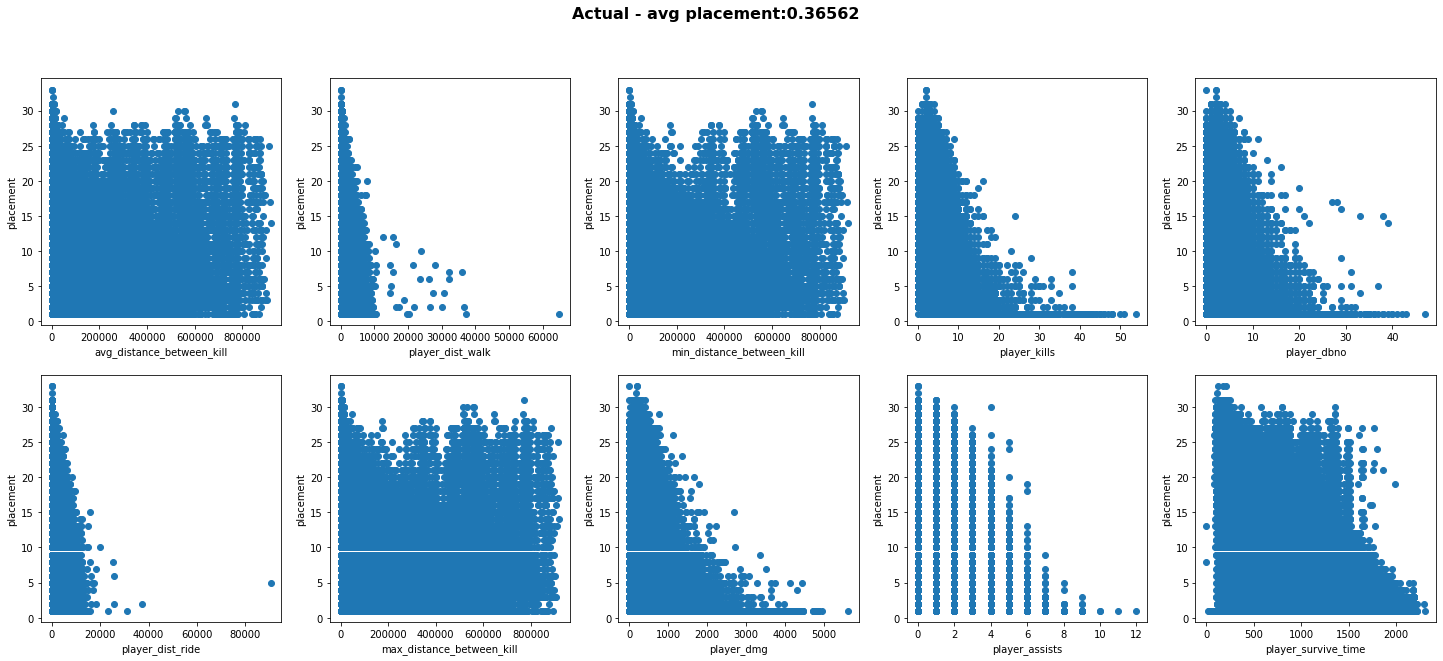

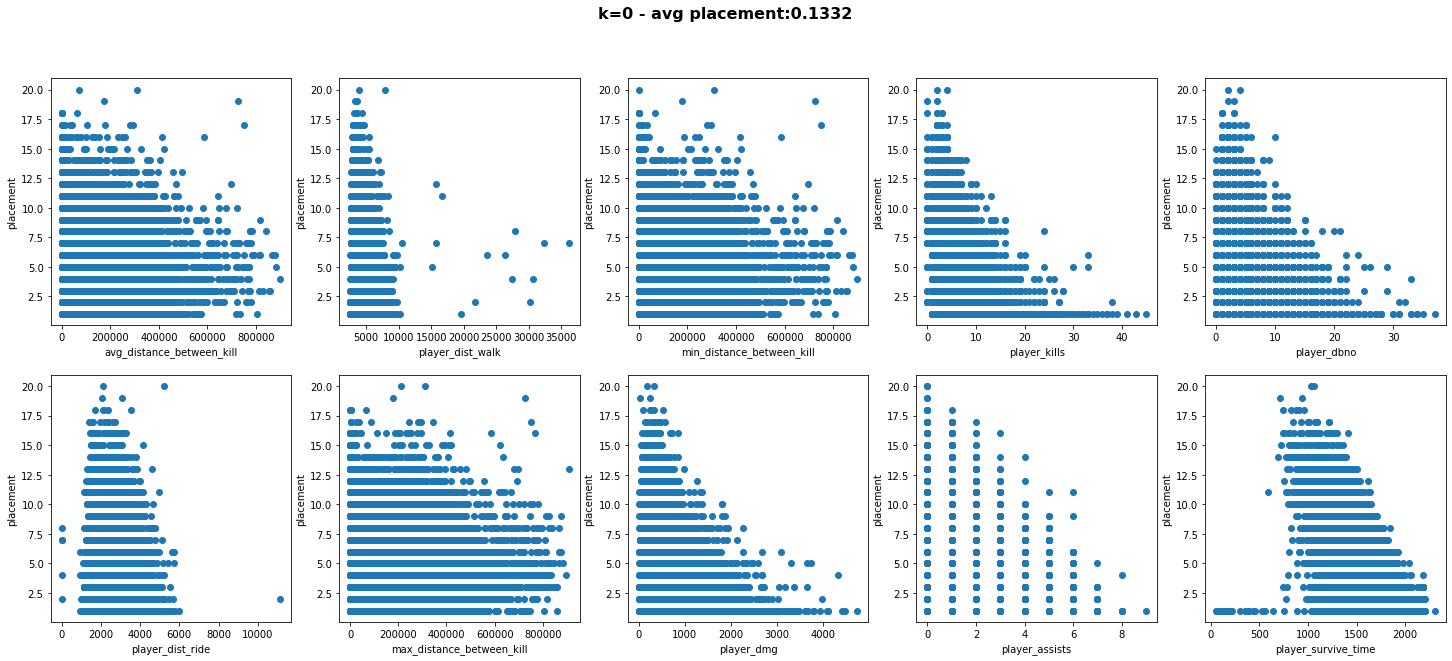

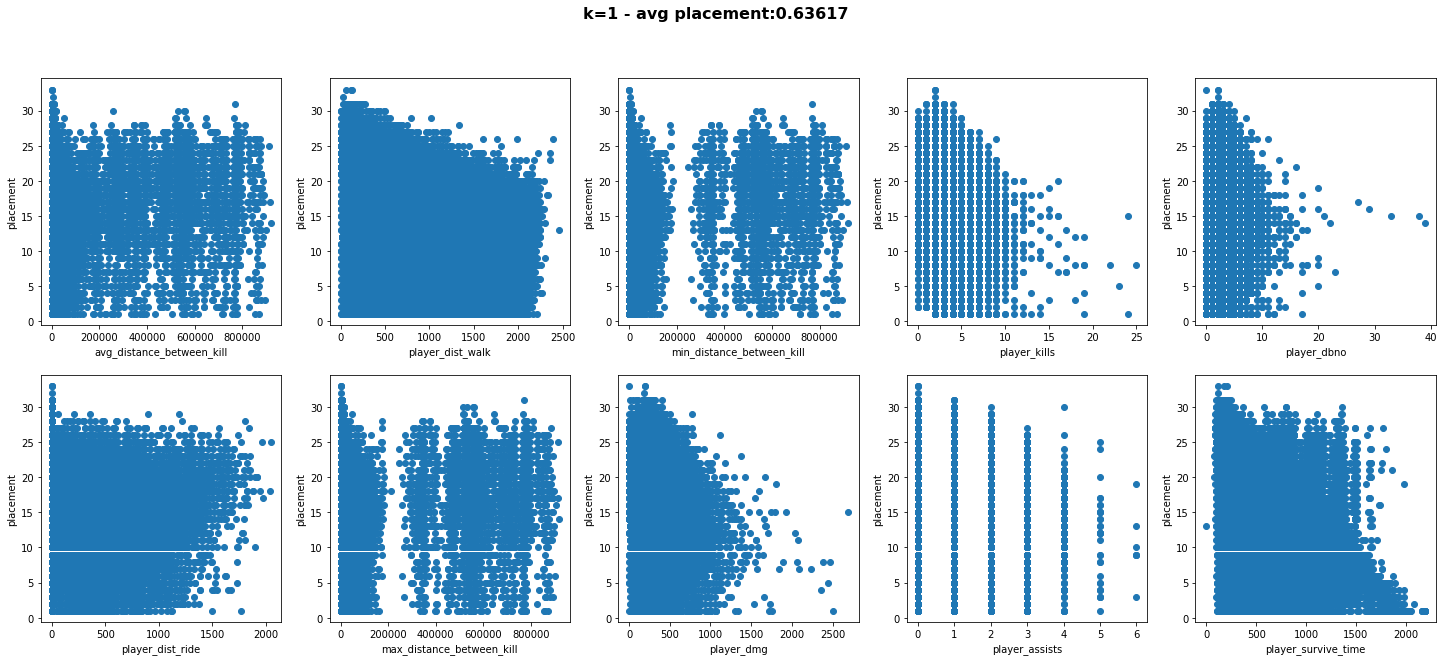

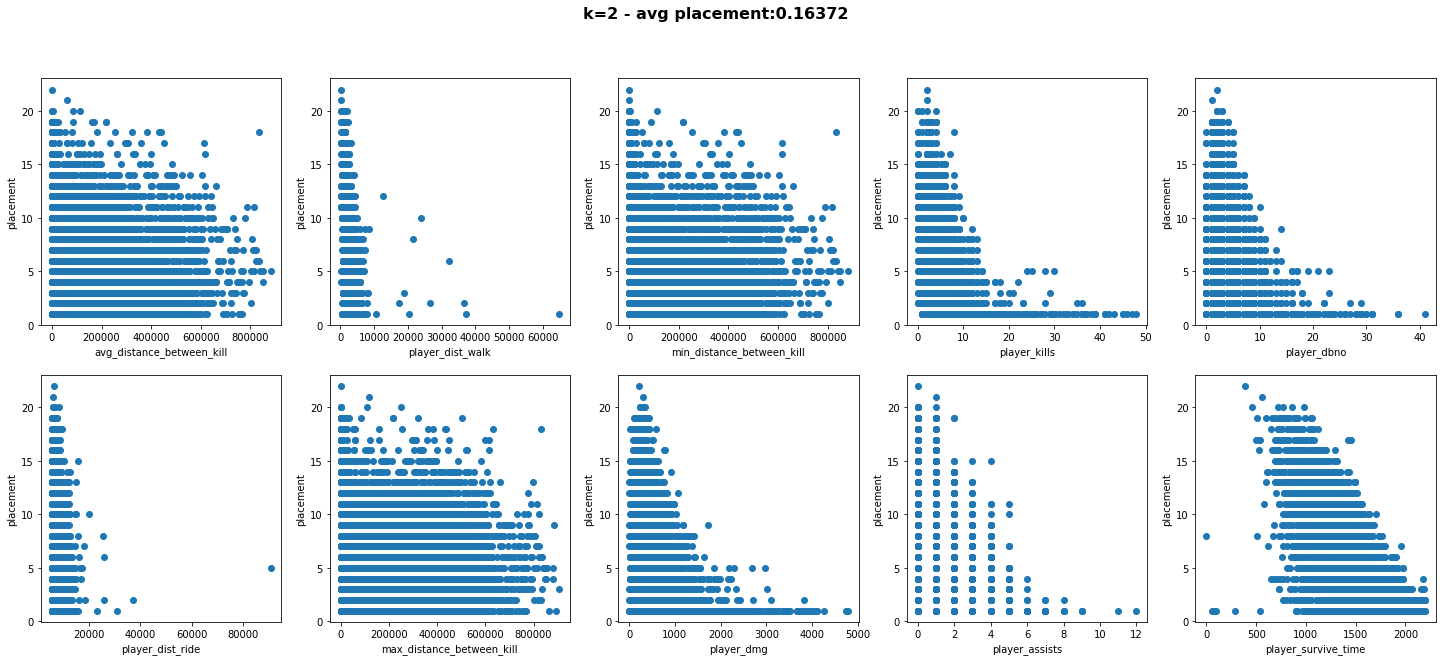

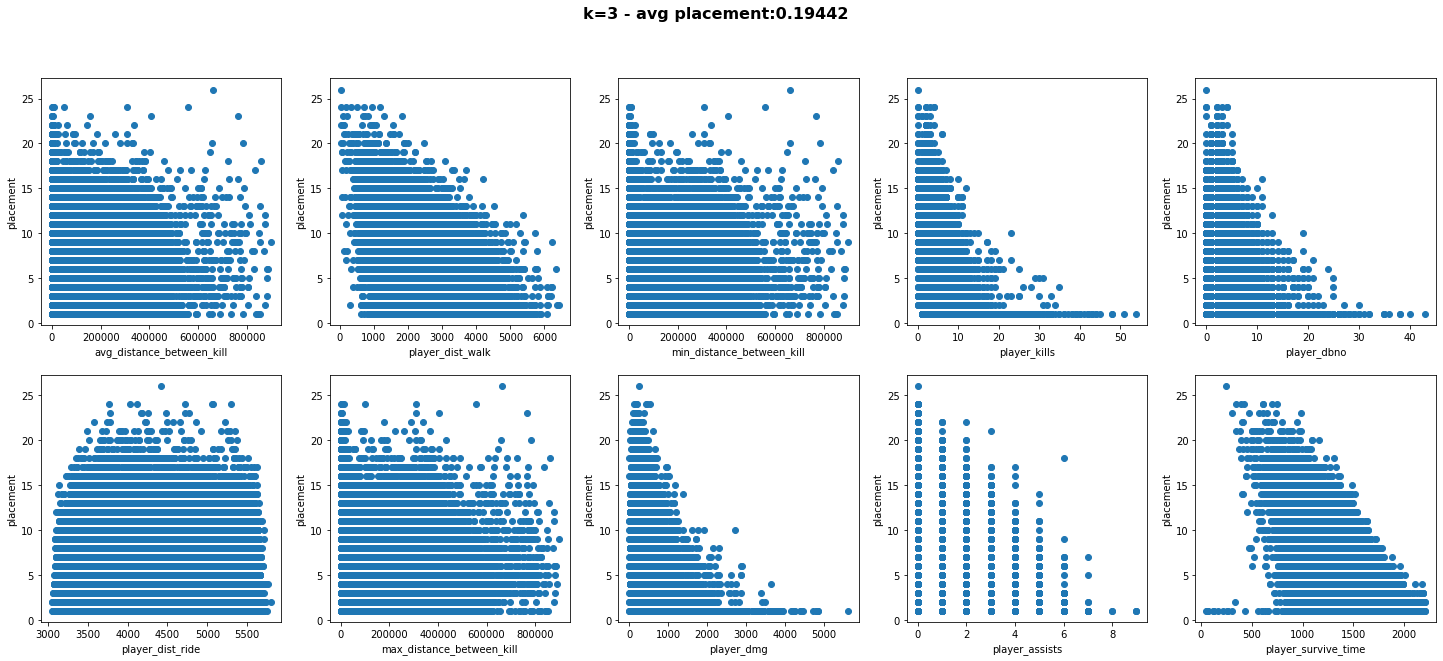

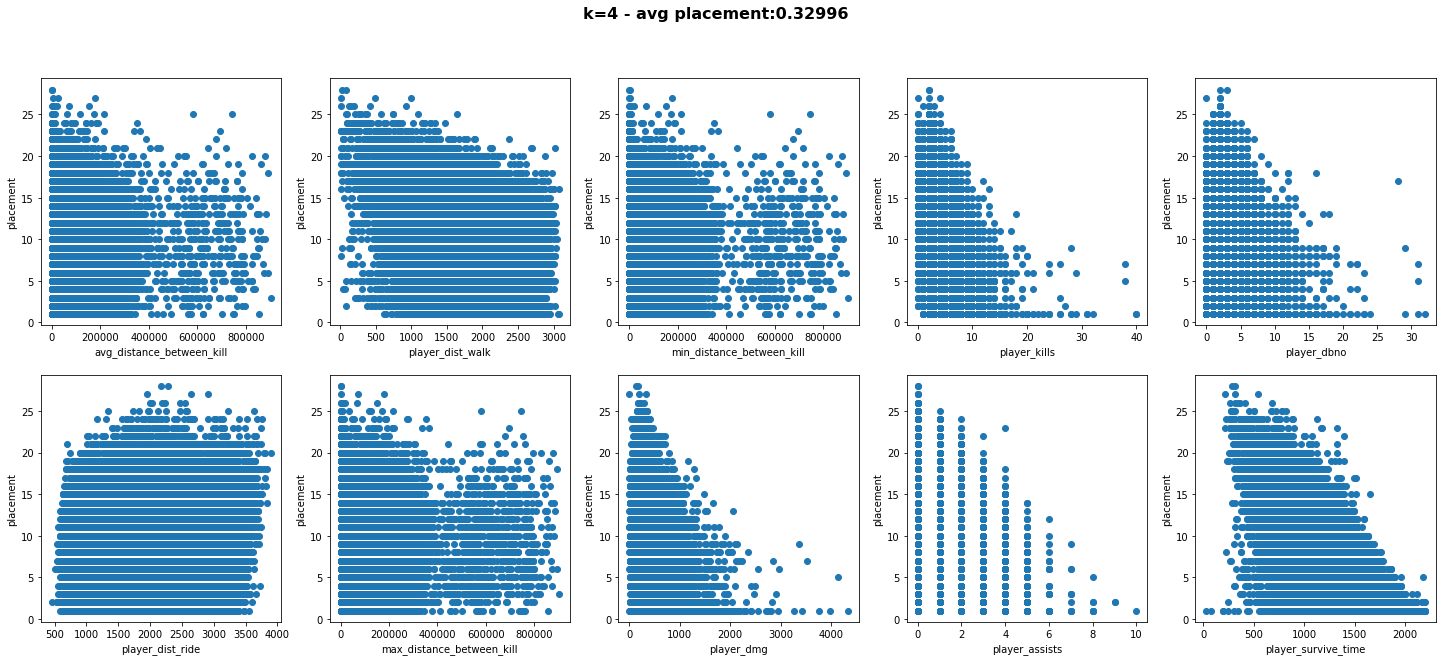

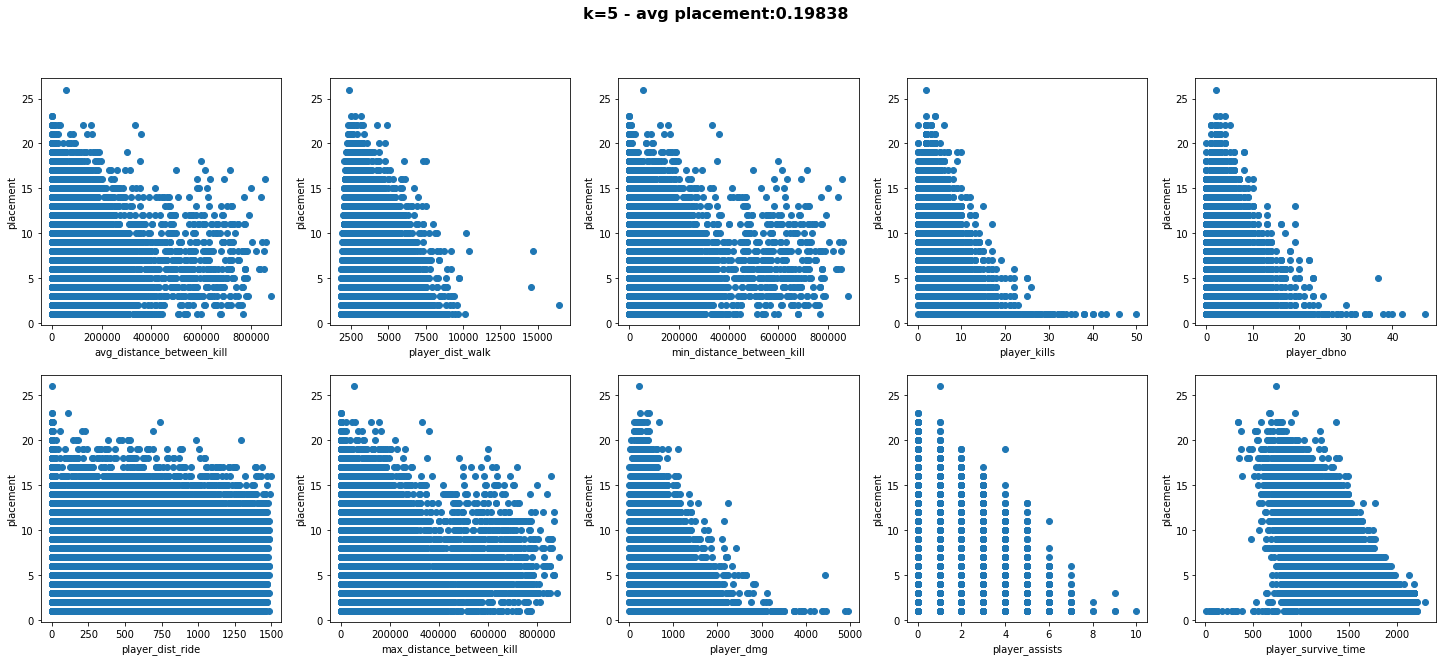

In [32]:
cnt=0
fig, axs = plt.subplots(2,5,figsize=(25,10))
fig.suptitle("Actual - avg placement:"+str(round(df_sqad['tmp'].mean(),5)),size=16,fontweight="bold")
for i in np.setdiff1d(df_sqad1.columns, ['team_placement']):
    y = df_sqad['team_placement'].values
    x = df_sqad[i].values
    axs[cnt%2,cnt%5].scatter(x, y)
    axs[cnt%2,cnt%5].set(xlabel=i, ylabel='placement')
    # axs[cnt%2,cnt%5].set_title("avg placement:"+str(round(df_sqad['tmp'].mean(),5)))
    cnt+=1
plt.show()

for j in range(6):
    fig, axs = plt.subplots(2,5,figsize=(25,10))
    df_tmp = df_sqad[df_sqad.predict==j]
    fig.suptitle("k="+str(j)+" - avg placement:"+str(round(df_tmp['tmp'].mean(),5)),size=16,fontweight="bold")
    cnt=0
    for i in np.setdiff1d(df_sqad1.columns, ['team_placement']):
        y = df_tmp['team_placement'].values
        x = df_tmp[i].values
        axs[cnt%2,cnt%5].scatter(x, y)
        axs[cnt%2,cnt%5].set(xlabel=i, ylabel='placement')
        # axs[cnt%2,cnt%5].set_title("avg placement:"+str(round(df_tmp['tmp'].mean(),5)))
        cnt+=1
    plt.show()

player_assists


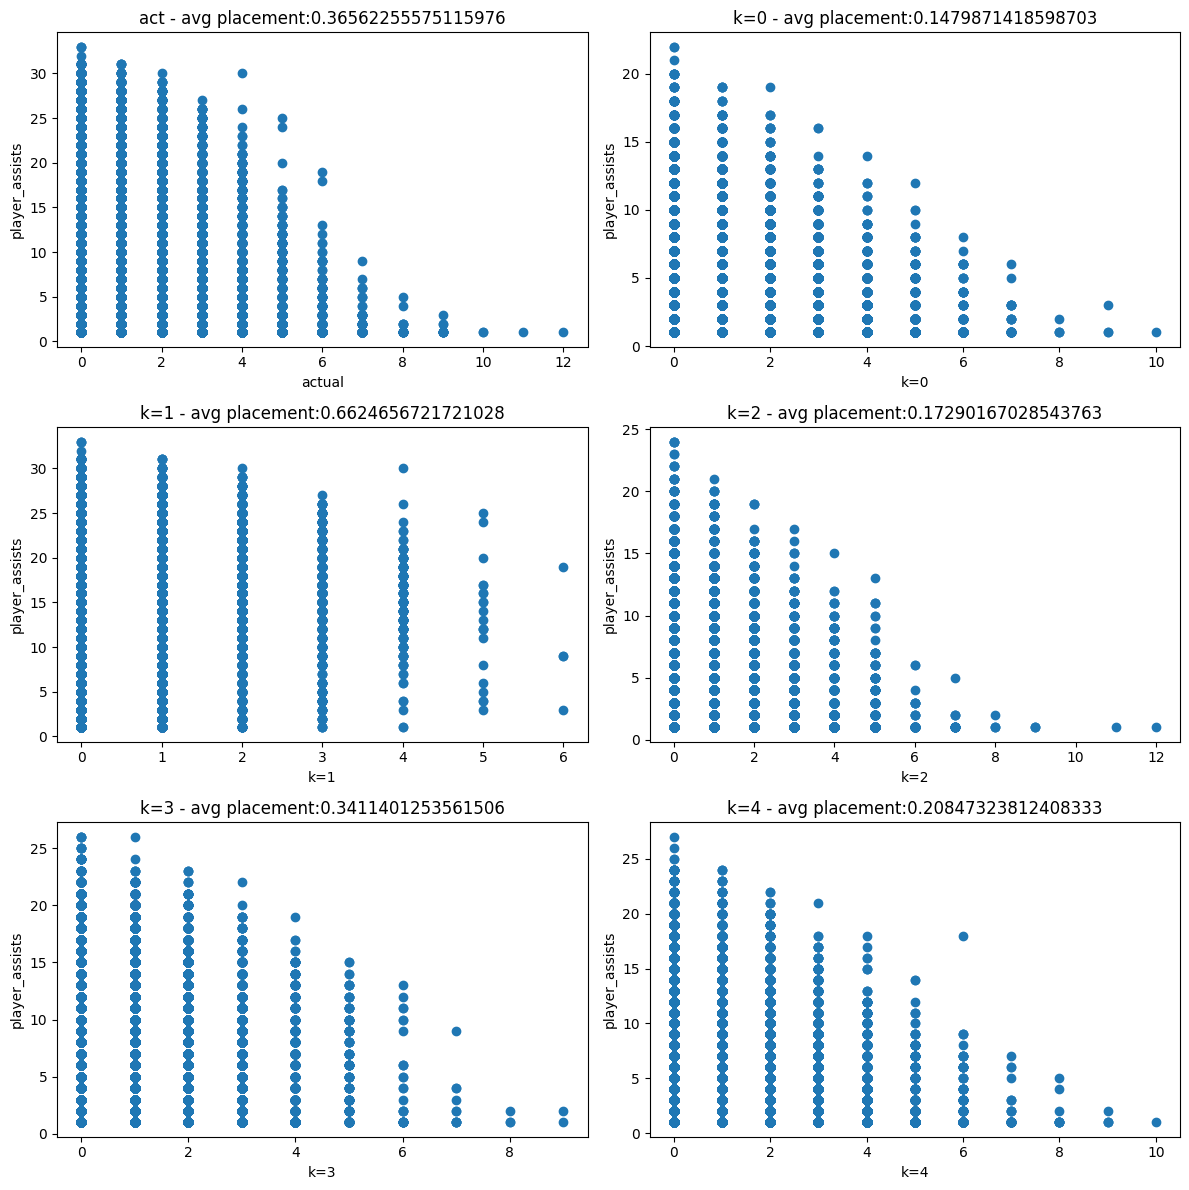

player_dbno


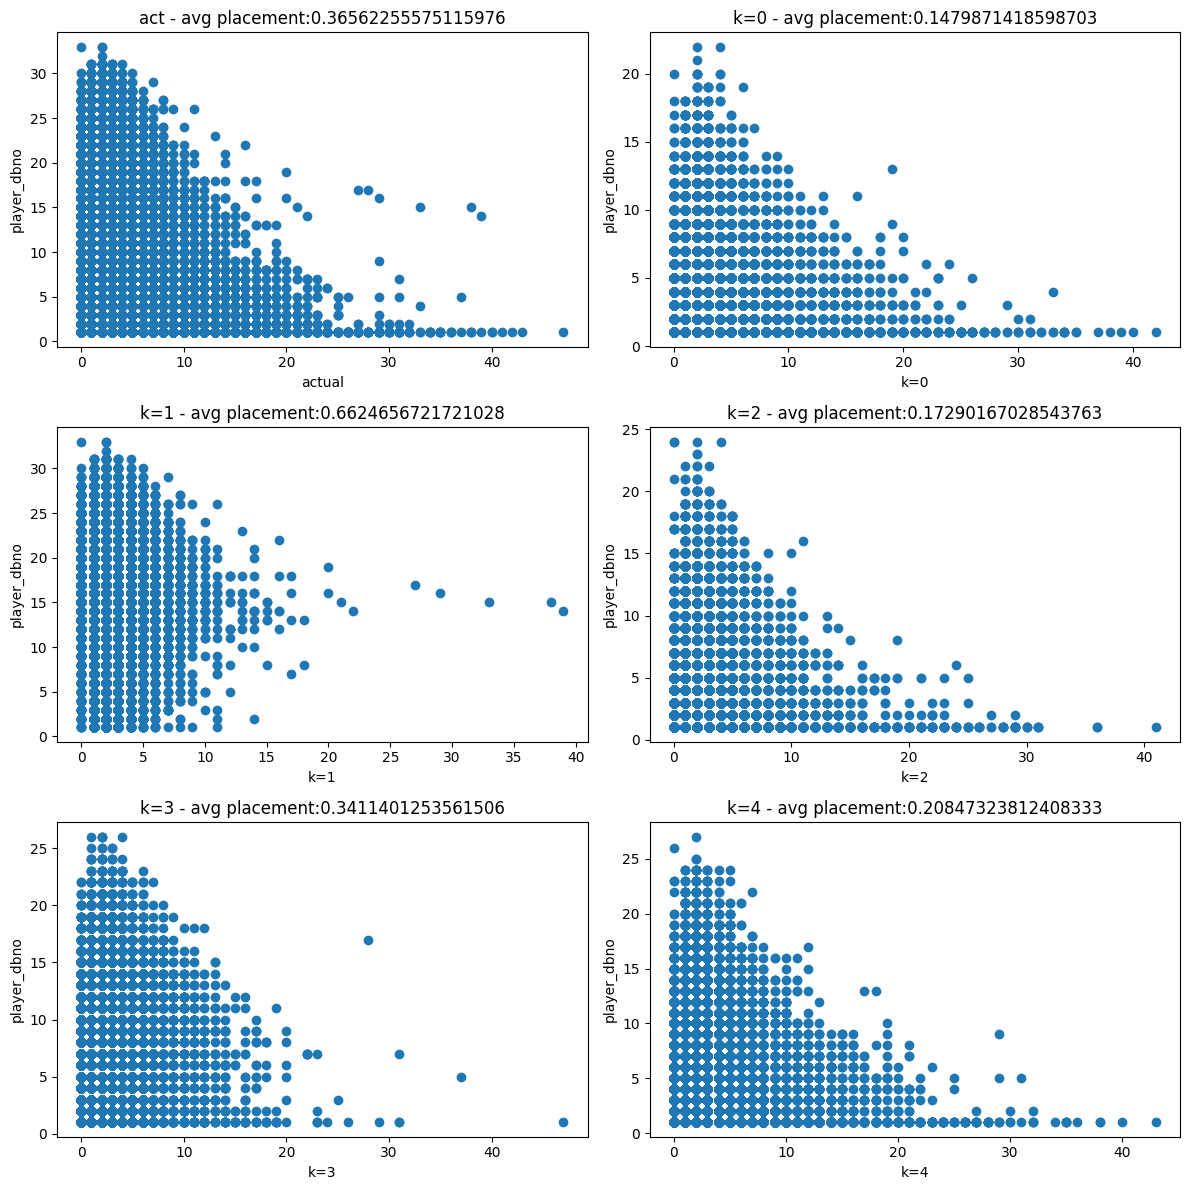

player_dist_ride


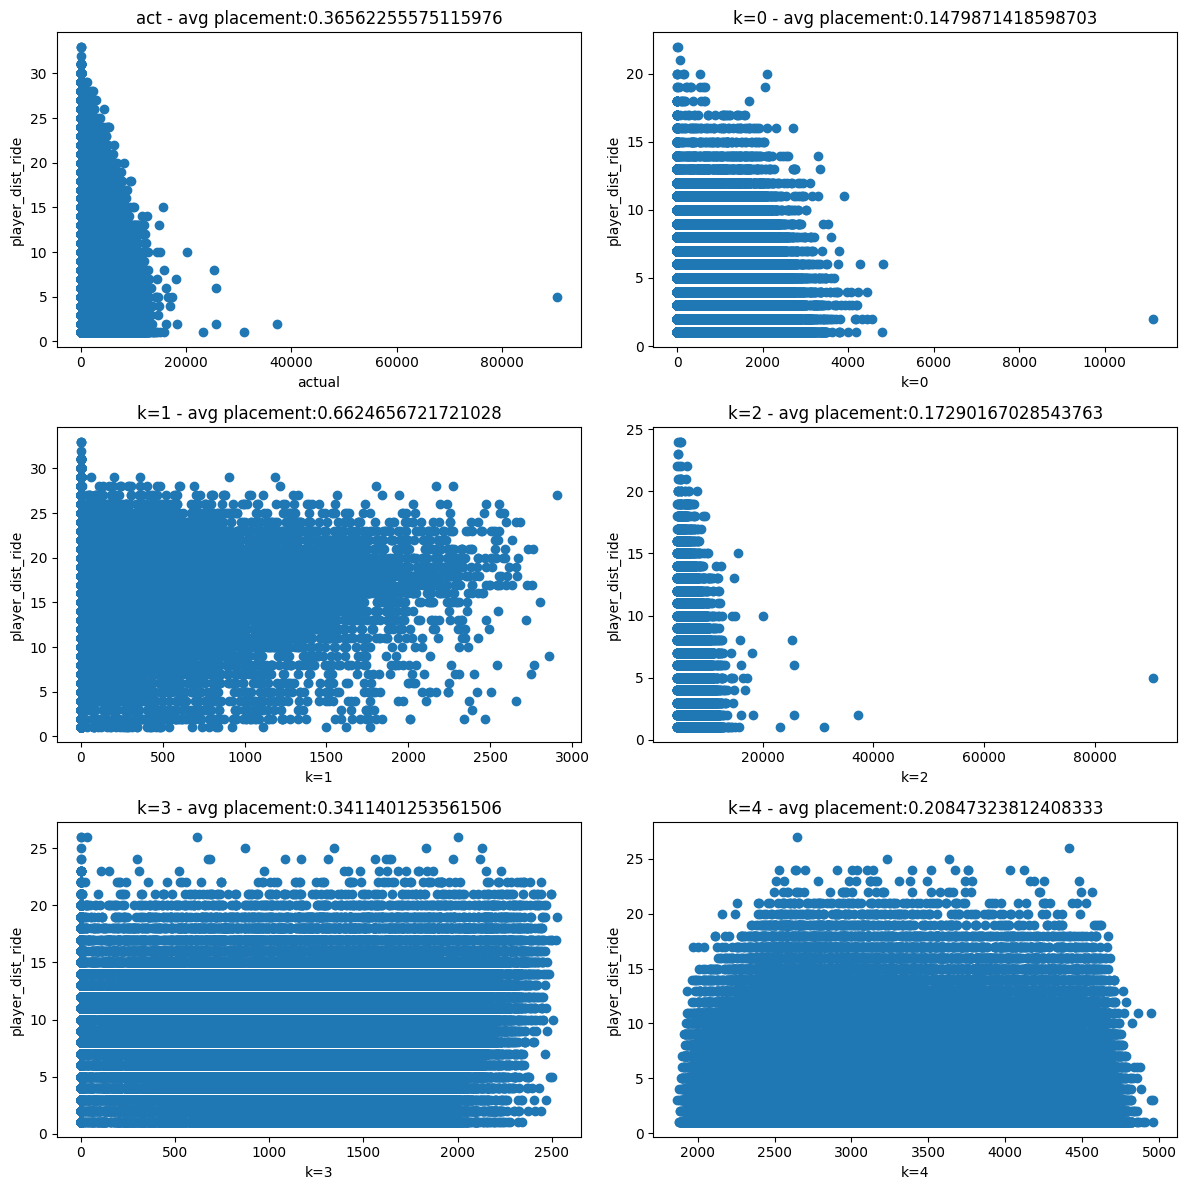

player_dist_walk


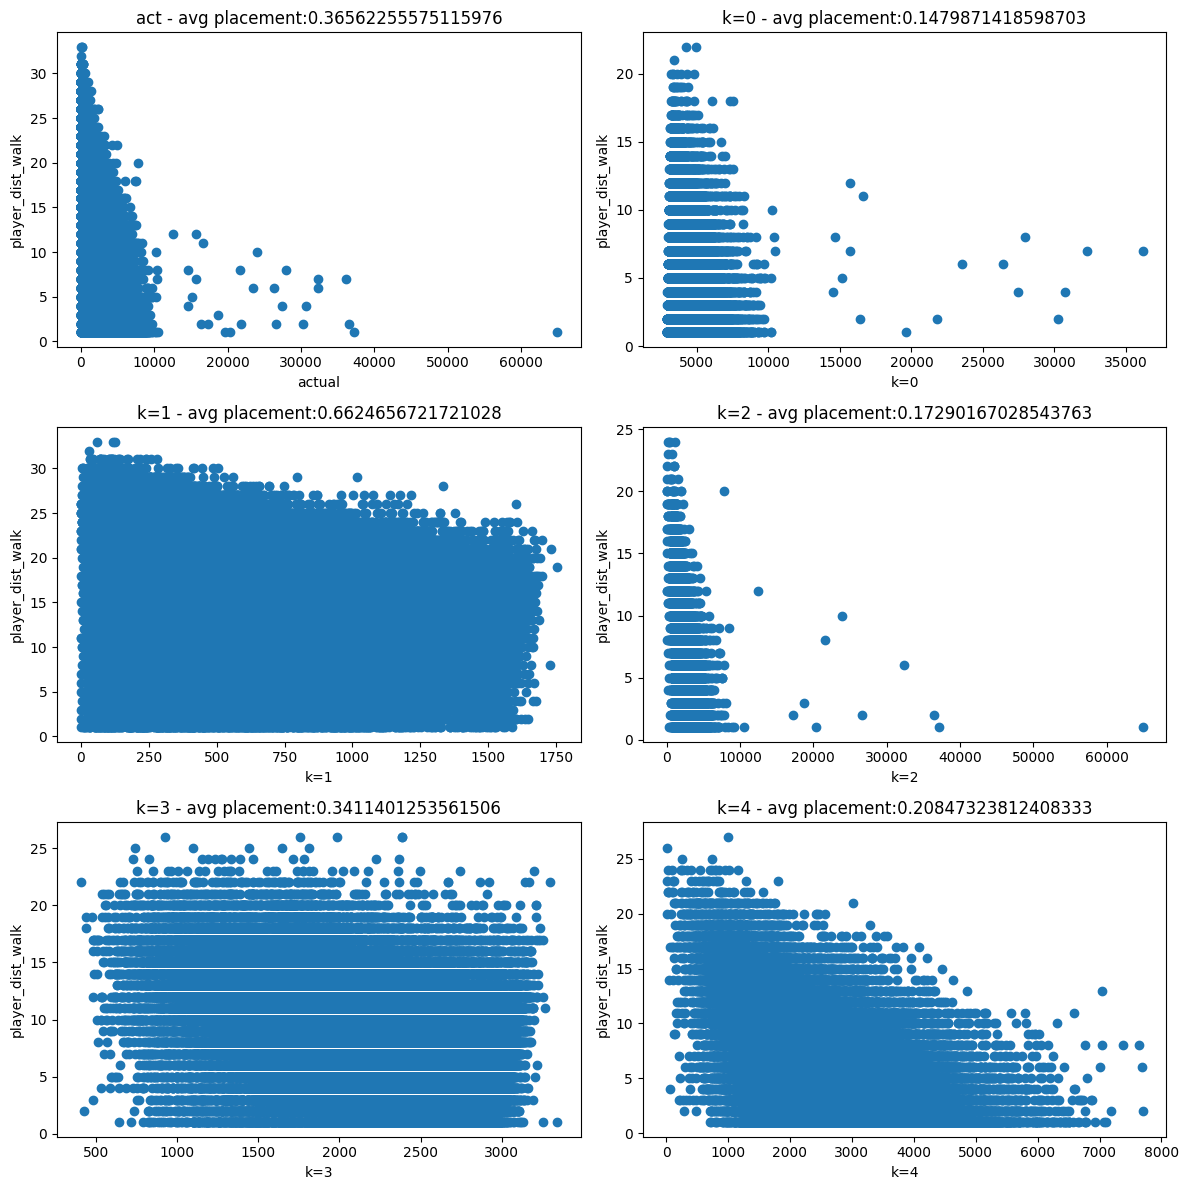

player_dmg


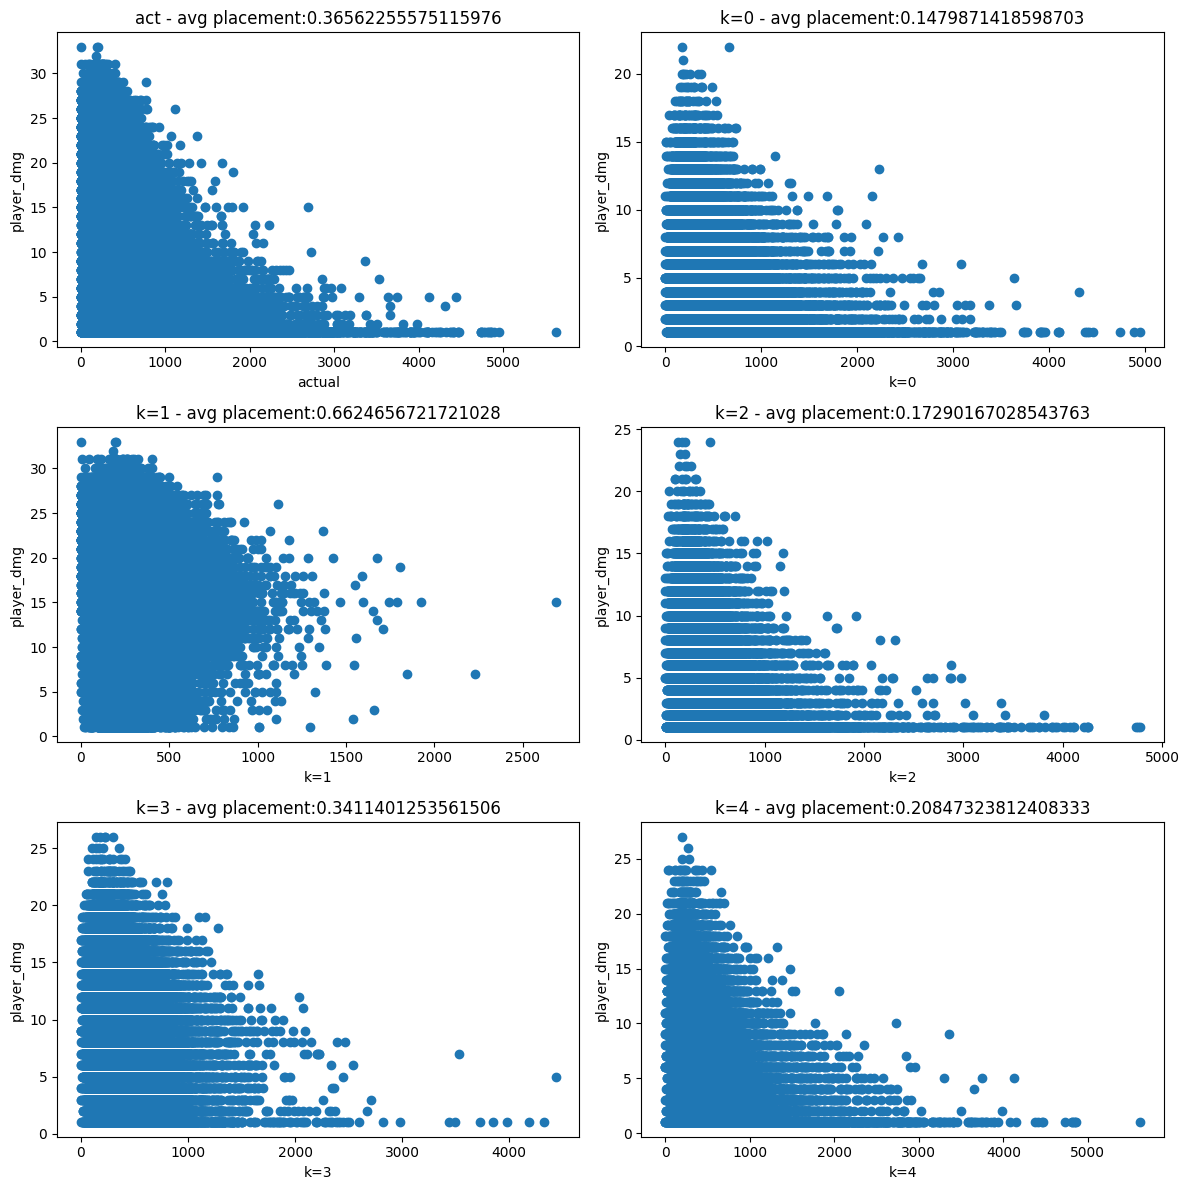

player_kills


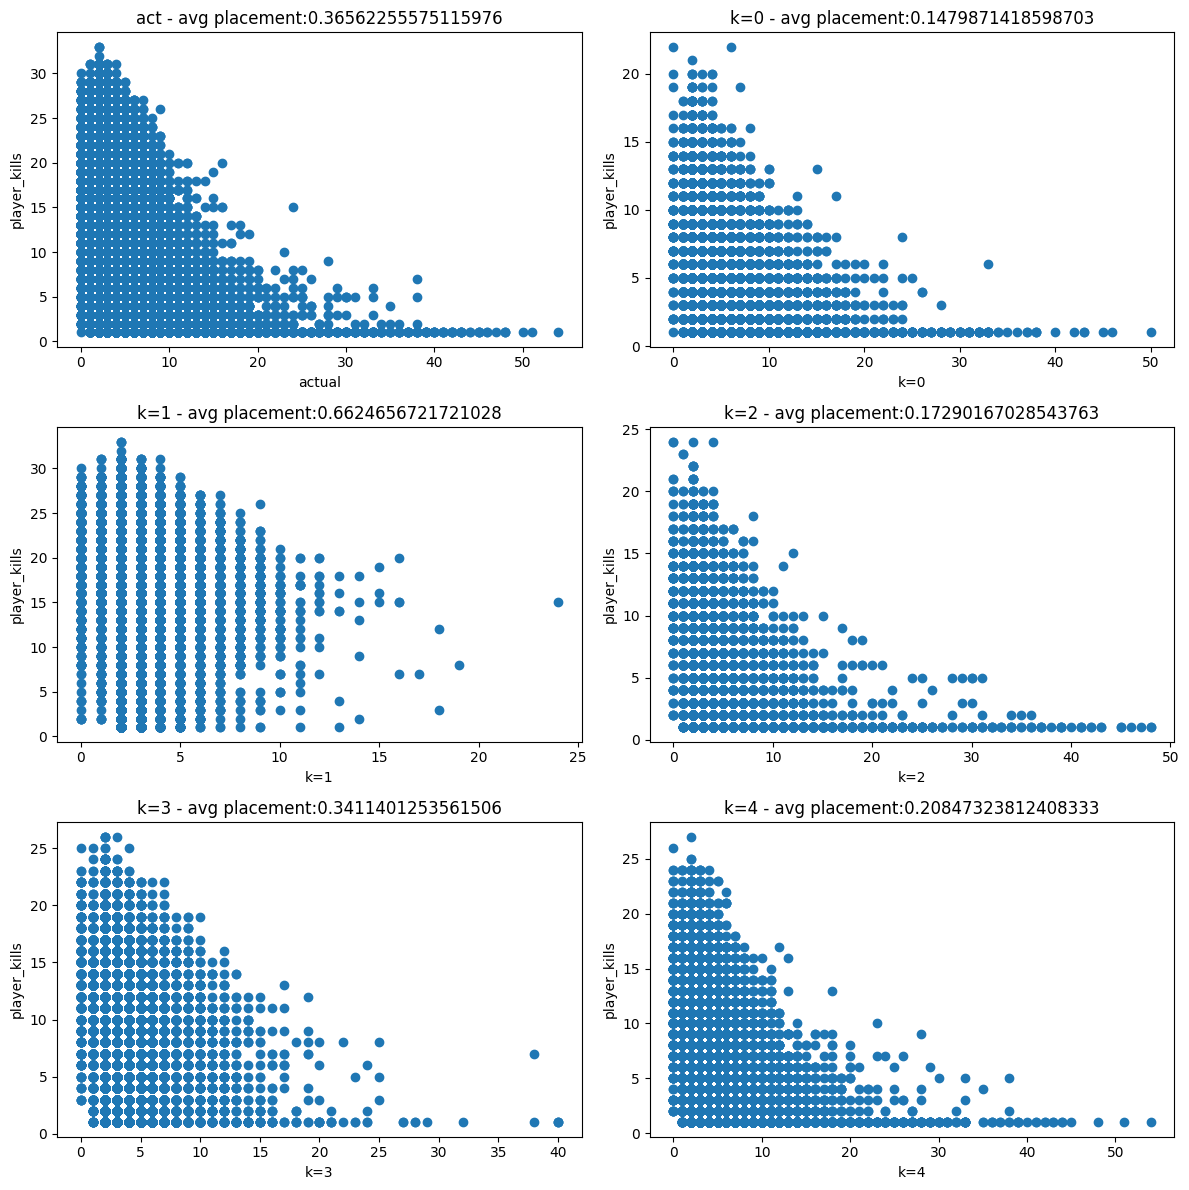

player_survive_time


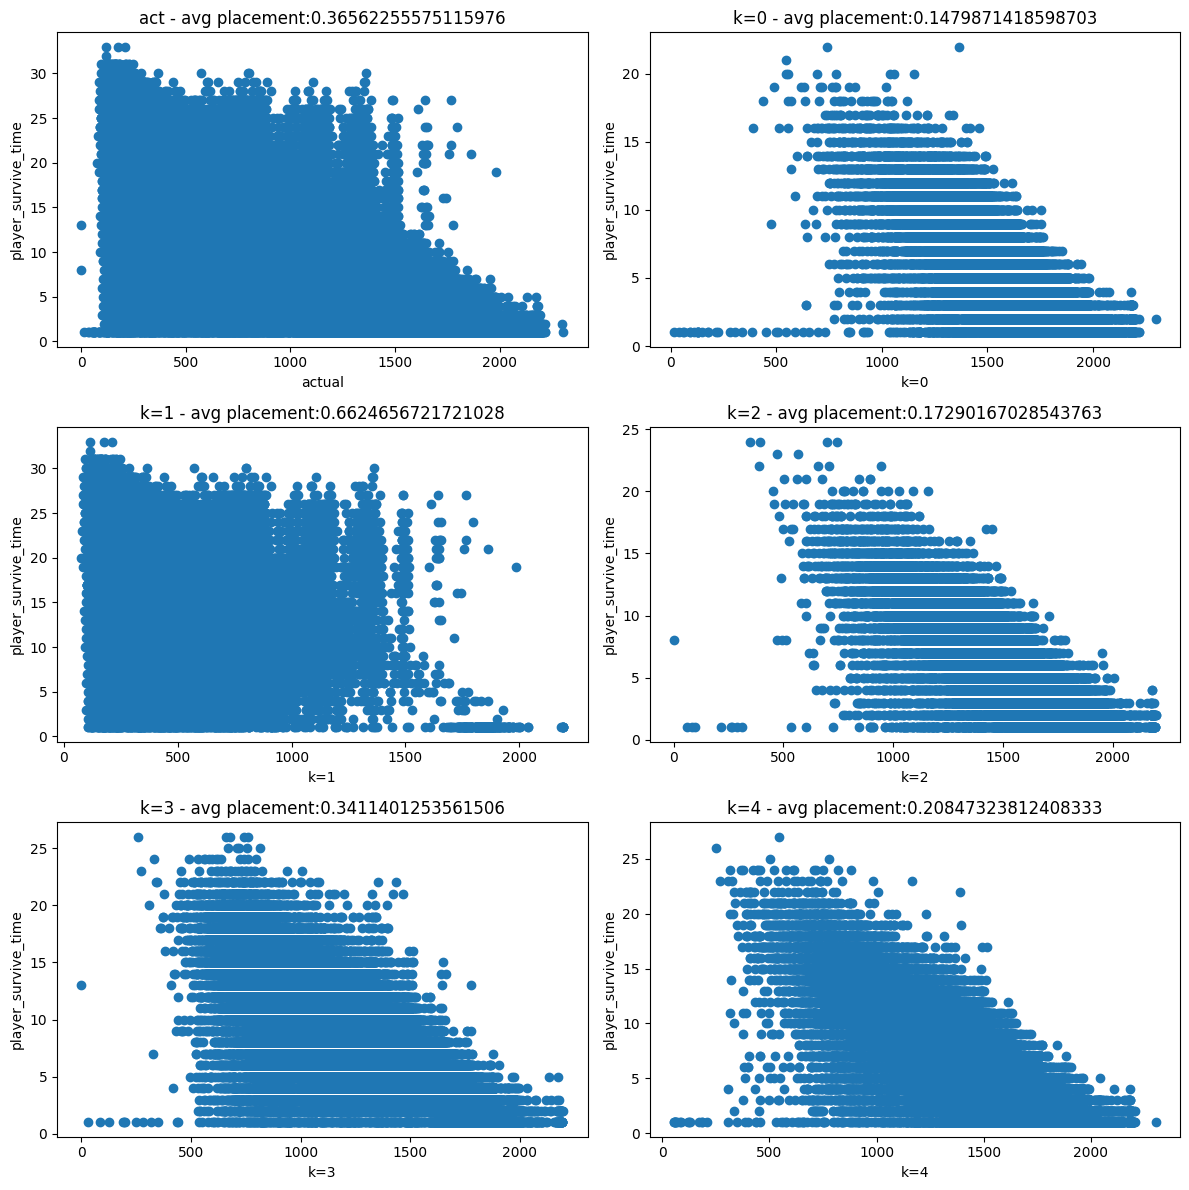

team_placement


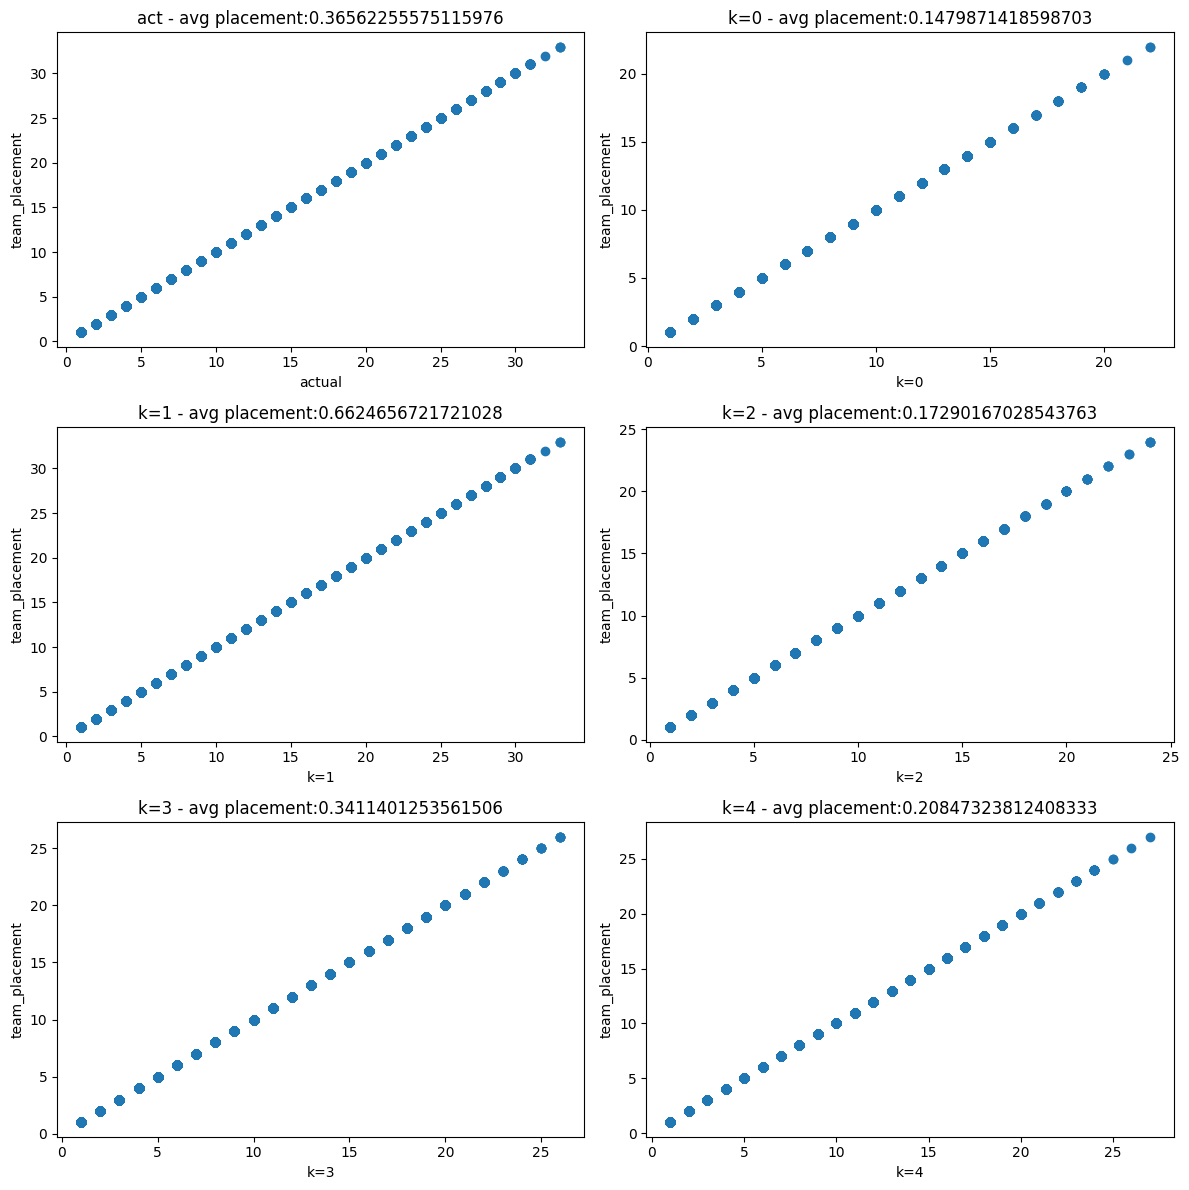

avg_distance_between_kill


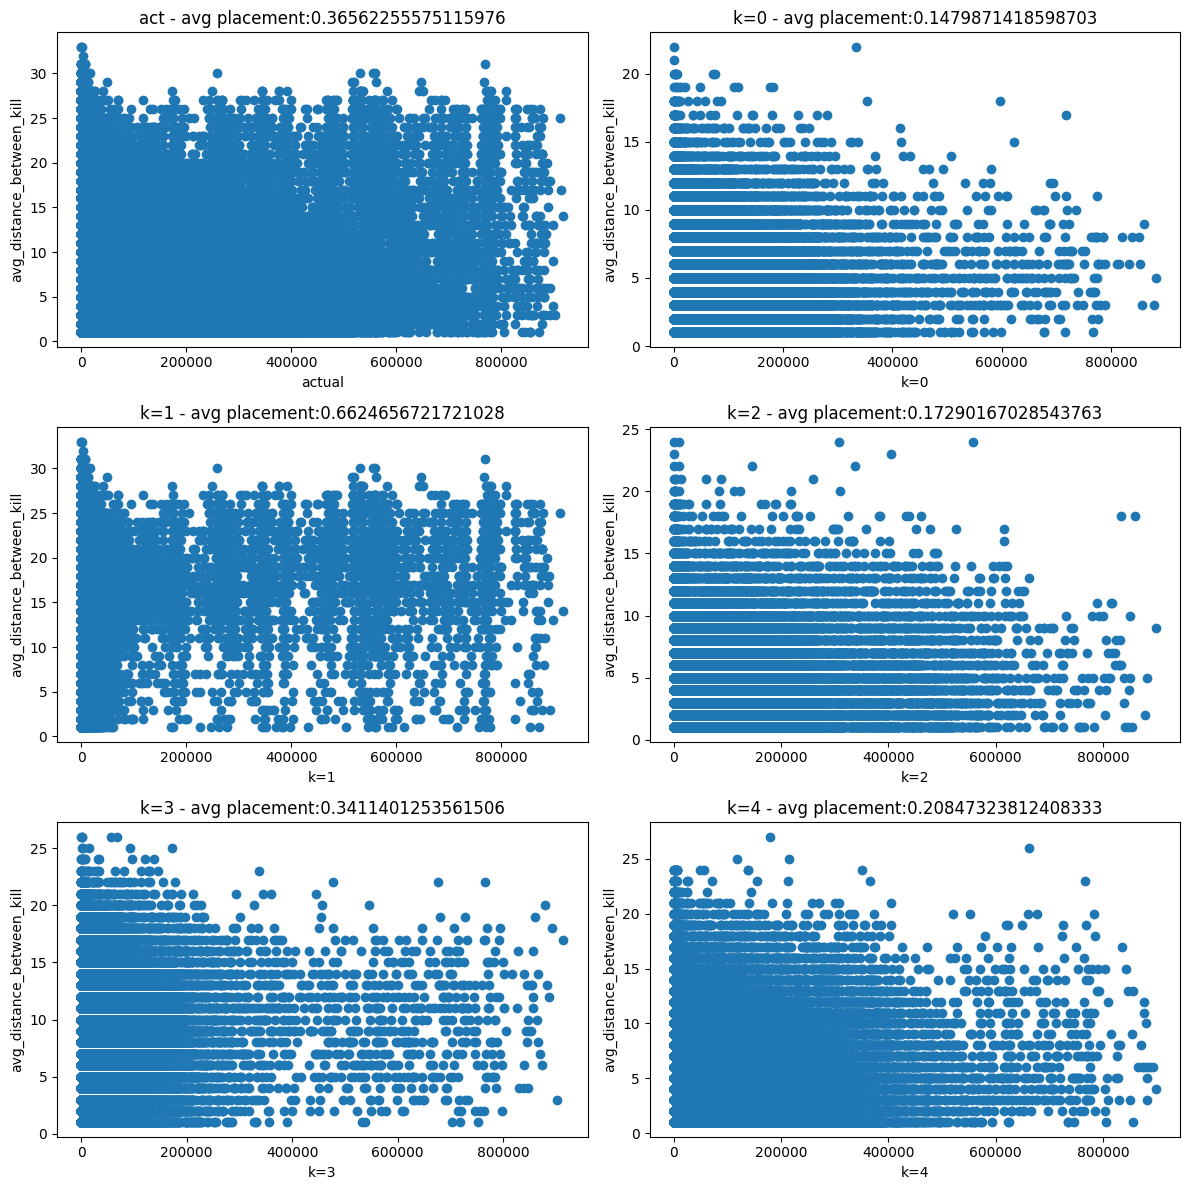

min_distance_between_kill


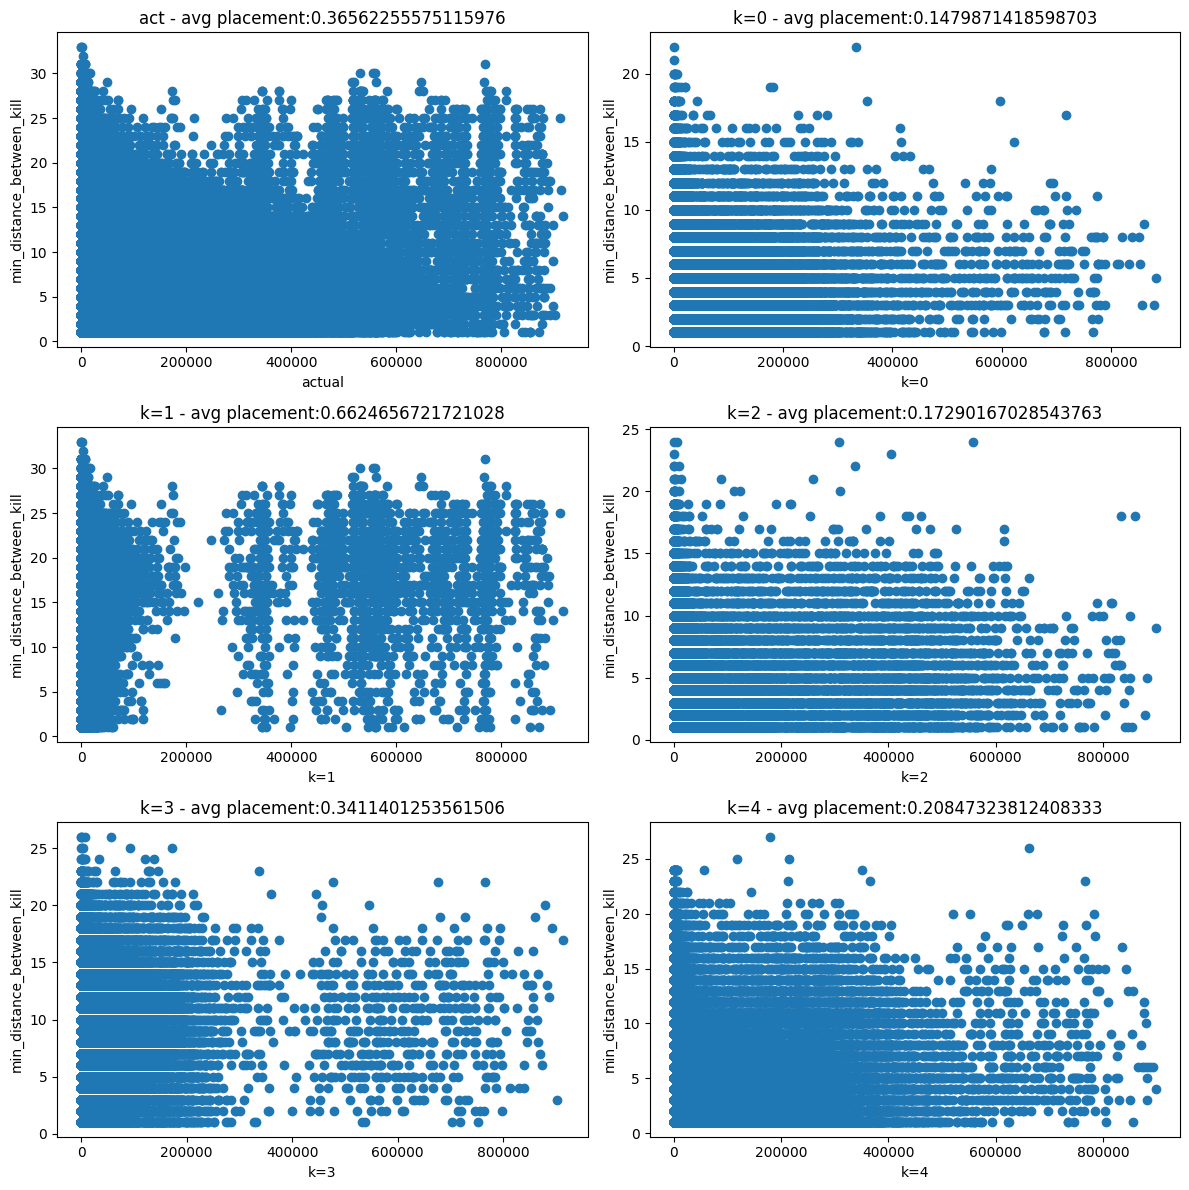

max_distance_between_kill


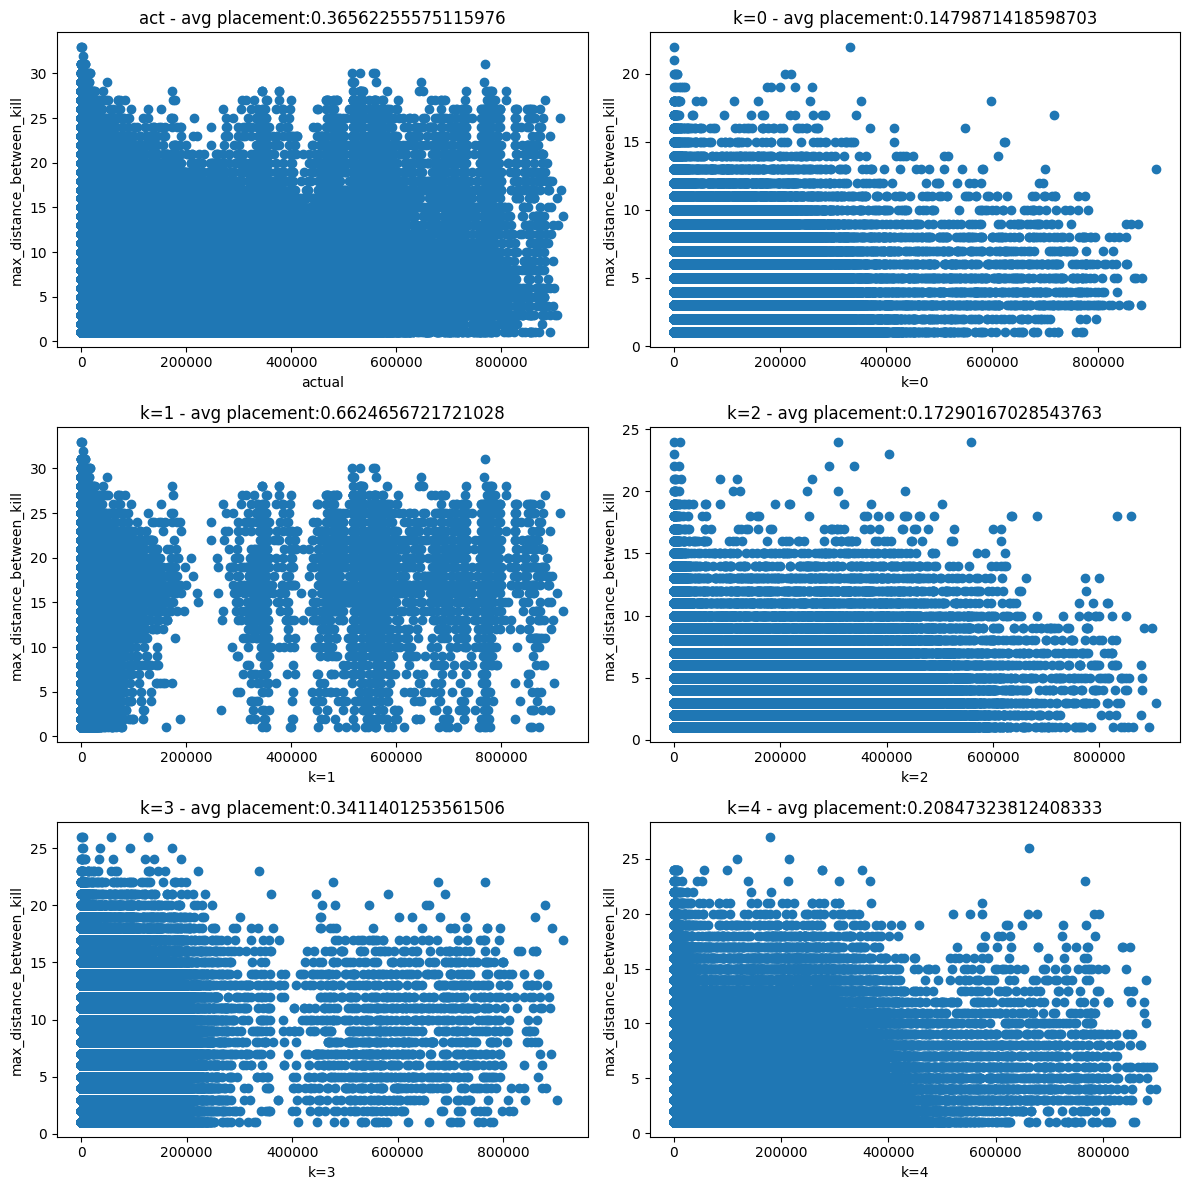

In [18]:
for i in df_sqad1.columns:
    print(i)
    y = df_sqad['team_placement'].values
    x = df_sqad[i].values
    fig, axs = plt.subplots(3,2,figsize=(12,12))
    axs[0,0].scatter(x, y)
    axs[0,0].set(xlabel=i, ylabel='placement')
    axs[0,0].set_title("act - avg placement:"+str(df_sqad['tmp'].mean()))
    df_tmp = df_sqad[df_sqad.predict==0]
    y = df_tmp['team_placement'].values
    x = df_tmp[i].values
    axs[0,1].scatter(x, y)
    axs[0,1].set(xlabel=i, ylabel='placement')
    axs[0,1].set_title("k=0 - avg placement:"+str(df_tmp['tmp'].mean()))
    df_tmp = df_sqad[df_sqad.predict==1]
    y = df_tmp['team_placement'].values
    x = df_tmp[i].values
    axs[1,0].scatter(x, y)
    axs[1,0].set(xlabel=i, ylabel='placement')
    axs[1,0].set_title("k=1 - avg placement:"+str(df_tmp['tmp'].mean()))
    df_tmp = df_sqad[df_sqad.predict==2]
    y = df_tmp['team_placement'].values
    x = df_tmp[i].values
    axs[1,1].scatter(x, y)
    axs[1,1].set(xlabel=i, ylabel='placement')
    axs[1,1].set_title("k=2 - avg placement:"+str(df_tmp['tmp'].mean()))
    df_tmp = df_sqad[df_sqad.predict==3]
    y = df_tmp['team_placement'].values
    x = df_tmp[i].values
    axs[2,0].scatter(x, y)
    axs[2,0].set(xlabel=i, ylabel='placement')
    axs[2,0].set_title("k=3 - avg placement:"+str(df_tmp['tmp'].mean()))
    df_tmp = df_sqad[df_sqad.predict==4]
    y = df_tmp['team_placement'].values
    x = df_tmp[i].values
    axs[2,1].scatter(x, y)
    axs[2,1].set(xlabel=i, ylabel='placement')
    axs[2,1].set_title("k=4 - avg placement:"+str(df_tmp['tmp'].mean()))
    fig.tight_layout()
    plt.show()

In [6]:
def dbscan(df,cols,e,s):
    km = cluster.DBSCAN(eps=e,min_samples=s)
    tmp = df[cols].values
    km = km.fit(tmp)
    t = km.labels_
    print(set(t),[(i,np.count_nonzero(t == i)) for i in set(t)])
    if len(set(t))==1:
        t=-1
    else:
        t = metrics.davies_bouldin_score(tmp, km.labels_)
    return {"eps":e,"min_samples":s,"error":t}


In [ ]:
dbscan(df_sqad,cols[:7],1000,700)